# Advanced Machine Learning Lesson : Materials Science
> Advanced Machine Learning (advanced linear regression)
> Author: Raunak Mondal
- toc: true
- categories: []
- type: pbl
- week: 18

#**Lesson: Exploring Materials Project Data and Predicting Material Properties**
##**Step 1: Importing Libraries**
In this lesson, we'll explore materials project data and perform various data analysis tasks using Python. First, we need to import the necessary libraries to work with data, visualize it, and perform machine learning.

In [ ]:
from mp_api.client import MPRester
import pandas as pd
from pymatgen.core import Composition
import datetime
from math import inf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_validate, KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_predict, cross_validate, KFold
#from sklearn.metrics import r2_score
#from sklearn.cluster import KMeans
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#from sklearn.linear_model import LogisticRegression
#from sklearn.cluster import DBSCAN

##**Step 2: Accessing Materials Project Data**
The Materials Project is a database containing materials properties data. We'll use the MPRester library to access materials project data related to ABO3 compounds. We'll fetch properties like material_id, formula_pretty, nsites, band_gap, formation_energy_per_atom, theoretical, and energy_above_hull for all ABO3 compounds.

In [ ]:
mpr = MPRester(api_key="PT7C2S6MEfO67wSwPtB3KlVvUu7ZI166")

In [ ]:
ABO3 = mpr.summary.search(formula="**O3", fields=["material_id", "formula_pretty", "nsites", "band_gap", "formation_energy_per_atom", "theoretical", "energy_above_hull"])

Retrieving SummaryDoc documents:   0%|          | 0/2544 [00:00<?, ?it/s]

In [ ]:
ABO3_dicts = [i.dict() for i in ABO3]

In [ ]:
mp_database = pd.DataFrame(data=ABO3_dicts)

## **Step 3: Data Manipulation and Cleaning**
Now that we have the materials project data in a DataFrame named 'mp_database,' let's clean and manipulate the data to make it more suitable for analysis.


In [ ]:
mp_database = mp_database.drop("fields_not_requested", axis=1)

In [ ]:
len(mp_database)

2544

In [ ]:
grouped = mp_database.groupby('formula_pretty').size()

In [ ]:
grouped.mean()

1.912781954887218

In [ ]:
mp_database.nunique()

nsites                         18
formula_pretty               1330
material_id                  2544
formation_energy_per_atom    2544
energy_above_hull            2199
band_gap                     1297
theoretical                     2
dtype: int64

In [ ]:
mp_database

,nsites,formula_pretty,material_id,formation_energy_per_atom,energy_above_hull,band_gap,theoretical
0,20,NaNbO3,mp-4681,-2.833432,0.012851,2.3684,False
1,10,MnZnO3,mp-754318,-1.814413,0.005794,1.3225,True
2,20,MnAlO3,mp-1368992,-2.573144,0.161167,0.5506,True
3,5,BaBiO3,mp-545783,-2.222888,0.021211,0.0000,False
4,20,MnTlO3,mp-770870,-1.505971,0.053737,0.0000,True
...,...,...,...,...,...,...,...
2539,5,BaCdO3,mp-1183292,-1.645883,0.202881,0.0000,True
2540,10,LaMnO3,mp-1205375,-2.968812,0.161878,0.0000,False
2541,5,TlSiO3,mp-1187529,-1.862867,0.534038,0.0000,True
2542,5,GdBeO3,mp-1184468,-2.874174,0.315310,0.0000,True


In [ ]:
mp_database['theoretical'].value_counts()[False]

836

In [ ]:
mp_database['formation_energy_per_atom_ev_mol'] = mp_database['formation_energy_per_atom'] * 96491.5666

In [ ]:
mp_database

,nsites,formula_pretty,material_id,formation_energy_per_atom,energy_above_hull,band_gap,theoretical,formation_energy_per_atom_ev_mol
0,20,NaNbO3,mp-4681,-2.833432,0.012851,2.3684,False,-273402.322598
1,10,MnZnO3,mp-754318,-1.814413,0.005794,1.3225,True,-175075.572015
2,20,MnAlO3,mp-1368992,-2.573144,0.161167,0.5506,True,-248286.682798
3,5,BaBiO3,mp-545783,-2.222888,0.021211,0.0000,False,-214489.986143
4,20,MnTlO3,mp-770870,-1.505971,0.053737,0.0000,True,-145313.457382
...,...,...,...,...,...,...,...,...
2539,5,BaCdO3,mp-1183292,-1.645883,0.202881,0.0000,True,-158813.786775
2540,10,LaMnO3,mp-1205375,-2.968812,0.161878,0.0000,False,-286465.330840
2541,5,TlSiO3,mp-1187529,-1.862867,0.534038,0.0000,True,-179750.985874
2542,5,GdBeO3,mp-1184468,-2.874174,0.315310,0.0000,True,-277333.565860


##**Step 4: Classifying Materials**
Let's classify the materials based on their stability and band gap properties. We'll define two functions, 'stability_category' and 'bandgap_category,' to perform the classification.

In [ ]:
# Assuming you already have a pandas DataFrame named 'mp_database' with columns 'energy_above_hull' and 'band_gap'

# Function to classify materials based on energy_above_hull
def stability_category(energy):
    if energy > 0.03:
        return 'unstable'
    else:
        return 'potentially_stable'

# Function to classify materials based on band_gap
def bandgap_category(band_gap):
    if band_gap == 0:
        return 'metal'
    elif 0 < band_gap <= 1:
        return 'small_bandgap'
    else:
        return 'large_bandgap'

# Apply the classification functions to the DataFrame
mp_database['stability'] = mp_database['energy_above_hull'].apply(stability_category)
mp_database['bandgap_type'] = mp_database['band_gap'].apply(bandgap_category)

# Create a pivot table to get the desired table structure
new_table = pd.pivot_table(mp_database, index='stability', columns='bandgap_type', aggfunc='size', fill_value=0)

# Reorder the columns to match the desired order
new_table = new_table[['metal', 'small_bandgap', 'large_bandgap']]

print(new_table)

bandgap_type        metal  small_bandgap  large_bandgap
stability                                              
potentially_stable    197            103            525
unstable             1042            212            465


In [ ]:
mp_database

,nsites,formula_pretty,material_id,formation_energy_per_atom,energy_above_hull,band_gap,theoretical,formation_energy_per_atom_ev_mol,stability,bandgap_type
0,20,NaNbO3,mp-4681,-2.833432,0.012851,2.3684,False,-273402.322598,potentially_stable,large_bandgap
1,10,MnZnO3,mp-754318,-1.814413,0.005794,1.3225,True,-175075.572015,potentially_stable,large_bandgap
2,20,MnAlO3,mp-1368992,-2.573144,0.161167,0.5506,True,-248286.682798,unstable,small_bandgap
3,5,BaBiO3,mp-545783,-2.222888,0.021211,0.0000,False,-214489.986143,potentially_stable,metal
4,20,MnTlO3,mp-770870,-1.505971,0.053737,0.0000,True,-145313.457382,unstable,metal
...,...,...,...,...,...,...,...,...,...,...
2539,5,BaCdO3,mp-1183292,-1.645883,0.202881,0.0000,True,-158813.786775,unstable,metal
2540,10,LaMnO3,mp-1205375,-2.968812,0.161878,0.0000,False,-286465.330840,unstable,metal
2541,5,TlSiO3,mp-1187529,-1.862867,0.534038,0.0000,True,-179750.985874,unstable,metal
2542,5,GdBeO3,mp-1184468,-2.874174,0.315310,0.0000,True,-277333.565860,unstable,metal


##**Step 5: Data Visualization - Formation Energy Distribution**
Visualizing data is crucial for understanding its distribution and characteristics. Let's create a histogram to visualize the distribution of formation energies per atom.

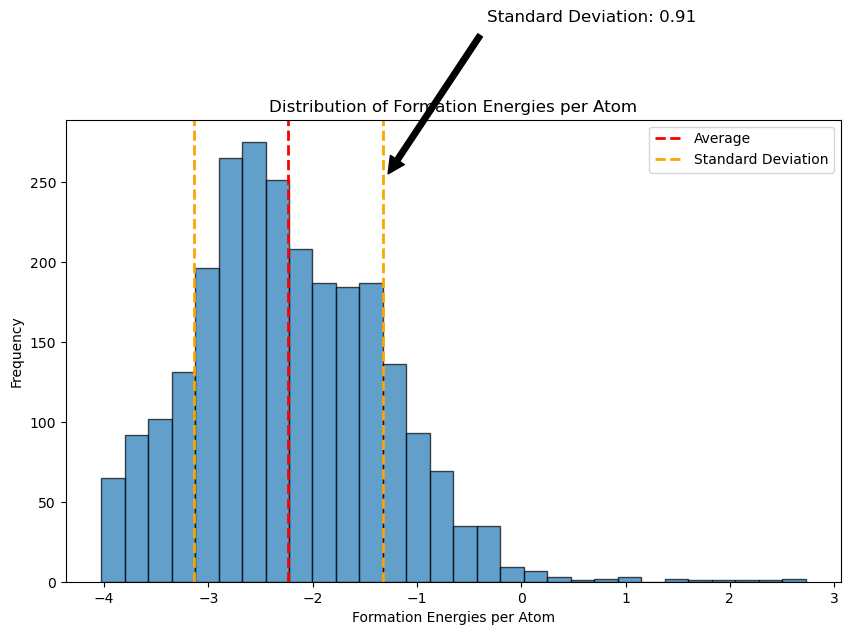

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named 'mp_database' with the 'formation_energies_per_atom' column

# Calculate the average and standard deviation
average_energy = mp_database['formation_energy_per_atom'].mean()
std_deviation = mp_database['formation_energy_per_atom'].std()

# Plot the distribution of the column
plt.figure(figsize=(10, 6))
plt.hist(mp_database['formation_energy_per_atom'], bins=30, edgecolor='black', alpha=0.7)

# Add labels and title to the plot
plt.xlabel('Formation Energies per Atom')
plt.ylabel('Frequency')
plt.title('Distribution of Formation Energies per Atom')

# Annotate the plot with average and standard deviation
plt.axvline(average_energy, color='red', linestyle='dashed', linewidth=2, label='Average')
plt.axvline(average_energy + std_deviation, color='orange', linestyle='dashed', linewidth=2, label='Standard Deviation')
plt.axvline(average_energy - std_deviation, color='orange', linestyle='dashed', linewidth=2)
plt.annotate(f'Average: {average_energy:.2f}', xy=(average_energy, 300), xytext=(average_energy + 0.5, 400),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.annotate(f'Standard Deviation: {std_deviation:.2f}', xy=(average_energy + std_deviation, 250),
             xytext=(average_energy + std_deviation + 1, 350), arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

# Show legend
plt.legend()

# Display the plot
plt.show()

##**Step 6: Filtering and Preparing Data for Analysis**
Next, we'll filter the data to keep only the most relevant materials. We'll sort the data based on formation energy and remove duplicate formulas to keep only the materials with the lowest formation energy for each formula.

In [ ]:
orig_data = pd.read_csv("data2022.csv", na_filter=False)

In [ ]:
len(orig_data)

681

In [ ]:
orig_data

,Unnamed: 0,task_id,formula,formation_energy_per_atom,e_above_hull,band_gap,has_bandstructure
0,297,mp-570140,AuBr,-0.125181,0.011579,1.9716,True
1,573,mp-1206190,ZnI6,0.387945,0.652470,0.1076,False
2,579,mp-1208424,TeBr4,-0.390060,0.000000,2.5202,False
3,738,mp-570480,TcBr4,-0.404404,0.000000,0.6025,True
4,880,mp-1064459,PBr,1.067789,1.327882,0.0000,False
...,...,...,...,...,...,...,...
676,118973,mp-974371,Rh3Br,0.670866,0.820678,0.0000,True
677,121600,mp-867231,TbI3,-1.382737,0.000000,2.0937,True
678,121602,mp-867247,TbBr3,-1.860767,0.000000,2.8570,True
679,121619,mp-867355,TeBr2,-0.186842,0.140200,0.6529,True


In [ ]:
import pandas as pd

# Assuming you have a pandas DataFrame named 'orig_data' with 'formation_energy_per_atom' and 'formula' columns

# Sort the DataFrame by 'formation_energy_per_atom' in ascending order
orig_data.sort_values(by='formation_energy_per_atom', ascending=True, inplace=True)

# Drop duplicates based on the 'formula' column and keep the first occurrence (smallest formation_energy_per_atom)
filtered_data = orig_data.drop_duplicates(subset='formula', keep='first')

# Display the resulting DataFrame
filtered_data

,Unnamed: 0,task_id,formula,formation_energy_per_atom,e_above_hull,band_gap,has_bandstructure
191,29313,mp-27456,BaBr2,-2.227832,0.000000,4.3731,True
475,80856,mp-567744,SrBr2,-2.156160,0.000000,4.4697,True
219,35022,mp-1071541,YbBr2,-2.109686,0.000000,4.3169,False
414,70294,mp-27972,AcBr3,-2.098107,0.000000,4.1045,True
304,51723,mp-22888,CaBr2,-2.052632,0.000000,4.5304,True
...,...,...,...,...,...,...,...
268,44109,mp-1184756,IrI,0.949140,1.047085,0.0000,False
601,105675,mp-1197830,CI,0.950707,0.950707,3.4057,False
541,93486,mp-975905,Mo3I,0.977325,1.122018,0.0000,True
517,88638,mp-1209830,PBr2,1.261139,1.607930,1.7322,False


In [ ]:
filtered_data = filtered_data[filtered_data["formation_energy_per_atom"] < 0]

In [ ]:
filtered_data

,Unnamed: 0,task_id,formula,formation_energy_per_atom,e_above_hull,band_gap,has_bandstructure
191,29313,mp-27456,BaBr2,-2.227832,0.000000,4.3731,True
475,80856,mp-567744,SrBr2,-2.156160,0.000000,4.4697,True
219,35022,mp-1071541,YbBr2,-2.109686,0.000000,4.3169,False
414,70294,mp-27972,AcBr3,-2.098107,0.000000,4.1045,True
304,51723,mp-22888,CaBr2,-2.052632,0.000000,4.5304,True
...,...,...,...,...,...,...,...
222,35973,mp-862773,TeI2,-0.036698,0.070018,0.7144,False
481,82174,mp-1185549,Mg149Br,-0.022094,0.000000,0.0021,False
600,105624,mp-1185590,Mg149I,-0.017586,0.000000,0.0025,False
512,87707,mp-1214775,AuBr2,-0.007624,0.143039,0.0000,False


## **Step 7: Calculating Composition-Averaged Properties**
We will now calculate the composition-averaged atomic radius for each material in 'filtered_data' using the element properties data available in 'element_data' DataFrame.

In [ ]:
element_data = pd.read_csv("element_properties.csv", index_col=0)

In [ ]:
element_data

,AtomicRadius,AtomicVolume,AtomicWeight,BoilingT,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,SecondIonizationEnergy
H,0.25,18618.051940,1.007940,20.13,31,0.0899,72.8,2.20,13.598443,14.304,NaN
He,NaN,37236.035560,4.002602,4.07,28,0.1785,0.0,NaN,24.587387,5.130,54.41776
Li,1.45,21.544058,6.941000,1615.00,128,535.0000,59.6,0.98,5.391719,3.582,75.64000
Be,1.05,8.098176,9.012182,2743.00,96,1848.0000,0.0,1.57,9.322700,1.825,18.21114
B,0.85,7.297767,10.811000,4273.00,84,2460.0000,26.7,2.04,8.298020,1.026,25.15480
...,...,...,...,...,...,...,...,...,...,...,...
Pa,1.80,24.961161,231.035860,4273.00,200,15370.0000,NaN,1.50,5.890000,NaN,NaN
U,1.75,20.748847,238.028910,4200.00,196,19050.0000,NaN,1.38,6.194100,0.116,10.60000
Np,1.75,19.244839,237.000000,4273.00,190,20450.0000,NaN,1.36,6.265700,NaN,NaN
Pu,1.75,20.447164,244.000000,3503.00,187,19816.0000,NaN,1.28,6.026000,NaN,11.20000


In [ ]:
type(element_data["AtomicRadius"][1])

numpy.float64

In [ ]:
comp = Composition('Al2O3')

In [ ]:
print(comp.elements)

[Element Al, Element O]


In [ ]:
print(comp.to_data_dict['unit_cell_composition'])

defaultdict(<class 'float'>, {'Al': 2.0, 'O': 3.0})


In [ ]:
import numpy as np

count = 0
column_nans = {}
for column in element_data.columns:
    for element in element_data[column]:
        if np.isnan(element):
            count += 1
    column_nans[column] = count
    count = 0

In [ ]:
column_nans

{'AtomicRadius': 7,
 'AtomicVolume': 2,
 'AtomicWeight': 0,
 'BoilingT': 2,
 'CovalentRadius': 0,
 'Density': 2,
 'ElectronAffinity': 9,
 'Electronegativity': 4,
 'FirstIonizationEnergy': 1,
 'HeatCapacityMass': 10,
 'SecondIonizationEnergy': 12}

In [ ]:
# Set of commands to compute the mean value for each column, replace the NaNs by the mean and output the updated data set
for i in element_data.columns:
    col_mean = element_data[i].mean(skipna=True)
    element_data[i] = element_data[i].fillna(col_mean)
element_data

,AtomicRadius,AtomicVolume,AtomicWeight,BoilingT,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,SecondIonizationEnergy
H,0.250000,18618.051940,1.007940,20.13,31,0.0899,72.800000,2.200000,13.598443,14.304000,18.947504
He,1.500682,37236.035560,4.002602,4.07,28,0.1785,0.000000,1.747033,24.587387,5.130000,54.417760
Li,1.450000,21.544058,6.941000,1615.00,128,535.0000,59.600000,0.980000,5.391719,3.582000,75.640000
Be,1.050000,8.098176,9.012182,2743.00,96,1848.0000,0.000000,1.570000,9.322700,1.825000,18.211140
B,0.850000,7.297767,10.811000,4273.00,84,2460.0000,26.700000,2.040000,8.298020,1.026000,25.154800
...,...,...,...,...,...,...,...,...,...,...,...
Pa,1.800000,24.961161,231.035860,4273.00,200,15370.0000,76.162209,1.500000,5.890000,0.635447,18.947504
U,1.750000,20.748847,238.028910,4200.00,196,19050.0000,76.162209,1.380000,6.194100,0.116000,10.600000
Np,1.750000,19.244839,237.000000,4273.00,190,20450.0000,76.162209,1.360000,6.265700,0.635447,18.947504
Pu,1.750000,20.447164,244.000000,3503.00,187,19816.0000,76.162209,1.280000,6.026000,0.635447,11.200000


In [ ]:
# Set of commands to compute and output the composition-averaged Atomic Radius for all materials
begin_time = datetime.datetime.now()
atomic_radius = pd.DataFrame()
filtered_data["composition_dict"] = [Composition(i).as_dict() for i in filtered_data.formula]
atomic_radius["formula"] = filtered_data.formula
atomic_radius["atomic_radius_avg"] = [np.average([element_data.loc[[el]]["AtomicRadius"][0] for el in comp], weights=[comp[el] for el in comp]) for comp in filtered_data.composition_dict]
print(datetime.datetime.now() - begin_time)
atomic_radius


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0:00:00.211715


,formula,atomic_radius_avg
191,BaBr2,1.483333
475,SrBr2,1.433333
219,YbBr2,1.350000
414,AcBr3,1.350000
304,CaBr2,1.366667
...,...,...
222,TeI2,1.400000
481,Mg149Br,1.497667
600,Mg149I,1.499333
512,AuBr2,1.216667


In [ ]:
atomic_radius_2 = pd.DataFrame()
atomic_radius_2["formula"] = filtered_data.formula
atomic_radius_2["composition_dict"] = filtered_data.composition_dict
composition_averaged_list = []
for composition in atomic_radius_2["composition_dict"]:
    total_atoms_in_formula = 0
    element_radius_weighted = 0
    for element in composition:
        total_atoms_in_formula += composition[element]
        element_radius_weighted += element_data.loc[element]["AtomicRadius"] * composition[element]
    average = element_radius_weighted / total_atoms_in_formula
    composition_averaged_list.append(average)
atomic_radius_2["atomic_radius_avg"] = composition_averaged_list

In [ ]:
atomic_radius_2

,formula,composition_dict,atomic_radius_avg
191,BaBr2,"{'Ba': 1.0, 'Br': 2.0}",1.483333
475,SrBr2,"{'Sr': 1.0, 'Br': 2.0}",1.433333
219,YbBr2,"{'Yb': 1.0, 'Br': 2.0}",1.350000
414,AcBr3,"{'Ac': 1.0, 'Br': 3.0}",1.350000
304,CaBr2,"{'Ca': 1.0, 'Br': 2.0}",1.366667
...,...,...,...
222,TeI2,"{'Te': 1.0, 'I': 2.0}",1.400000
481,Mg149Br,"{'Mg': 149.0, 'Br': 1.0}",1.497667
600,Mg149I,"{'Mg': 149.0, 'I': 1.0}",1.499333
512,AuBr2,"{'Au': 1.0, 'Br': 2.0}",1.216667


In [ ]:
average_properties = pd.DataFrame()
average_properties["formula"] = filtered_data.formula
average_properties["composition_dict"] = filtered_data.composition_dict
for prop in element_data.columns:
    composition_averaged_list = []
    for composition in average_properties["composition_dict"]:
        total_atoms_in_formula = 0
        element_property_weighted = 0
        for element in composition:
            total_atoms_in_formula += composition[element]
            element_property_weighted += element_data.loc[element][prop] * composition[element]
        average = element_property_weighted / total_atoms_in_formula
        composition_averaged_list.append(average)
    average_properties[prop] = composition_averaged_list

In [ ]:
average_properties

,formula,composition_dict,AtomicRadius,AtomicVolume,AtomicWeight,BoilingT,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,SecondIonizationEnergy
191,BaBr2,"{'Ba': 1.0, 'Br': 2.0}",1.483333,50.008311,99.045000,935.666667,151.666667,3250.000000,221.050000,2.270000,9.613088,0.384000,17.728610
475,SrBr2,"{'Sr': 1.0, 'Br': 2.0}",1.433333,46.792927,82.476000,773.000000,145.000000,2956.666667,218.076667,2.290000,9.774150,0.418000,18.070700
219,YbBr2,"{'Yb': 1.0, 'Br': 2.0}",1.350000,42.931774,110.954000,711.000000,142.333333,4270.000000,233.066667,2.393333,9.960587,0.367667,18.452667
414,AcBr3,"{'Ac': 1.0, 'Br': 3.0}",1.350000,41.254141,116.678000,1117.250000,143.750000,4857.500000,262.490552,2.495000,10.152850,0.385500,19.130750
304,CaBr2,"{'Ca': 1.0, 'Br': 2.0}",1.366667,42.664279,66.628667,807.000000,138.666667,2596.666667,217.190000,2.306667,9.913587,0.531667,18.351240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,TeI2,"{'Te': 1.0, 'I': 2.0}",1.400000,39.758135,127.136313,725.200000,138.666667,5373.333333,260.200000,2.473333,9.970707,0.210000,18.954200
481,Mg149Br,"{'Mg': 149.0, 'Br': 1.0}",1.497667,23.350997,24.675660,1356.126667,140.860000,1747.213333,2.164000,1.321000,7.674019,1.019340,15.078975
600,Mg149I,"{'Mg': 149.0, 'I': 1.0}",1.499333,23.351870,24.988996,1356.962000,140.986667,1759.346667,1.968000,1.319000,7.664935,1.017607,15.062577
512,AuBr2,"{'Au': 1.0, 'Br': 2.0}",1.216667,34.000905,118.924856,1264.333333,125.333333,8513.333333,290.666667,2.820000,10.951043,0.359000,21.127333


In [ ]:
max_properties = pd.DataFrame()
max_properties["formula"] = filtered_data.formula
max_properties["composition_dict"] = filtered_data.composition_dict
for prop in element_data.columns:
    composition_max_list = []
    max_property = 0
    for composition in max_properties["composition_dict"]:
        for element in composition:
            if element_data.loc[element][prop] > max_property:
                max_property = element_data.loc[element][prop]
        composition_max_list.append(max_property)
    max_properties[prop] = composition_max_list

In [ ]:
max_properties

,formula,composition_dict,AtomicRadius,AtomicVolume,AtomicWeight,BoilingT,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,SecondIonizationEnergy
191,BaBr2,"{'Ba': 1.0, 'Br': 2.0}",2.15,64.969282,137.327,2143.0,215.0,3510.0,324.6,2.96,11.813800,0.474,21.591
475,SrBr2,"{'Sr': 1.0, 'Br': 2.0}",2.15,64.969282,137.327,2143.0,215.0,3510.0,324.6,2.96,11.813800,0.474,21.591
219,YbBr2,"{'Yb': 1.0, 'Br': 2.0}",2.15,64.969282,173.054,2143.0,215.0,6570.0,324.6,2.96,11.813800,0.474,21.591
414,AcBr3,"{'Ac': 1.0, 'Br': 3.0}",2.15,64.969282,227.000,3473.0,215.0,10070.0,324.6,2.96,11.813800,0.474,21.591
304,CaBr2,"{'Ca': 1.0, 'Br': 2.0}",2.15,64.969282,227.000,3473.0,215.0,10070.0,324.6,2.96,11.813800,0.647,21.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,TeI2,"{'Te': 1.0, 'I': 2.0}",2.60,18618.051940,244.000,5869.0,244.0,22590.0,324.6,2.96,13.598443,14.304,75.640
481,Mg149Br,"{'Mg': 149.0, 'Br': 1.0}",2.60,18618.051940,244.000,5869.0,244.0,22590.0,324.6,2.96,13.598443,14.304,75.640
600,Mg149I,"{'Mg': 149.0, 'I': 1.0}",2.60,18618.051940,244.000,5869.0,244.0,22590.0,324.6,2.96,13.598443,14.304,75.640
512,AuBr2,"{'Au': 1.0, 'Br': 2.0}",2.60,18618.051940,244.000,5869.0,244.0,22590.0,324.6,2.96,13.598443,14.304,75.640


In [ ]:
min_properties = pd.DataFrame()
min_properties["formula"] = filtered_data.formula
min_properties["composition_dict"] = filtered_data.composition_dict
for prop in element_data.columns:
    composition_min_list = []
    min_property = inf
    for composition in min_properties["composition_dict"]:
        for element in composition:
            if element_data.loc[element][prop] < min_property:
                min_property = element_data.loc[element][prop]
        composition_min_list.append(min_property)
    min_properties[prop] = composition_min_list

In [ ]:
min_properties

,formula,composition_dict,AtomicRadius,AtomicVolume,AtomicWeight,BoilingT,CovalentRadius,Density,ElectronAffinity,Electronegativity,FirstIonizationEnergy,HeatCapacityMass,SecondIonizationEnergy
191,BaBr2,"{'Ba': 1.0, 'Br': 2.0}",1.15,42.527825,79.90400,332.00,120.0,3120.0000,13.95,0.89,5.211664,0.204,10.00383
475,SrBr2,"{'Sr': 1.0, 'Br': 2.0}",1.15,42.527825,79.90400,332.00,120.0,2630.0000,5.03,0.89,5.211664,0.204,10.00383
219,YbBr2,"{'Yb': 1.0, 'Br': 2.0}",1.15,42.527825,79.90400,332.00,120.0,2630.0000,5.03,0.89,5.211664,0.155,10.00383
414,AcBr3,"{'Ac': 1.0, 'Br': 3.0}",1.15,37.433086,79.90400,332.00,120.0,2630.0000,5.03,0.89,5.170000,0.120,10.00383
304,CaBr2,"{'Ca': 1.0, 'Br': 2.0}",1.15,37.433086,40.07800,332.00,120.0,1550.0000,2.37,0.89,5.170000,0.120,10.00383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,TeI2,"{'Te': 1.0, 'I': 2.0}",0.25,7.297767,1.00794,20.13,31.0,0.0899,0.00,0.79,3.893905,0.116,10.00383
481,Mg149Br,"{'Mg': 149.0, 'Br': 1.0}",0.25,7.297767,1.00794,20.13,31.0,0.0899,0.00,0.79,3.893905,0.116,10.00383
600,Mg149I,"{'Mg': 149.0, 'I': 1.0}",0.25,7.297767,1.00794,20.13,31.0,0.0899,0.00,0.79,3.893905,0.116,10.00383
512,AuBr2,"{'Au': 1.0, 'Br': 2.0}",0.25,7.297767,1.00794,20.13,31.0,0.0899,0.00,0.79,3.893905,0.116,10.00383


In [ ]:
average_properties = average_properties.drop("composition_dict", axis=1)
average_properties = average_properties.drop("formula", axis=1)
max_properties = max_properties.drop("composition_dict", axis=1)
max_properties = max_properties.drop("formula", axis=1)
min_properties = min_properties.drop("composition_dict", axis=1)
min_properties = min_properties.drop("formula", axis=1)

## **Step 8: Combining Property Data**
Next, we'll combine the composition-averaged, maximum, and minimum property DataFrames ('average_properties', 'max_properties', and 'min_properties') into a single design matrix DataFrame named 'design_matrix'.


In [ ]:
design_matrix = pd.concat([average_properties, max_properties, min_properties], axis=1)

## **Step 9: Splitting Data for Machine Learning**
To train and evaluate our machine learning model, we need to split the data into training and testing sets.

In [ ]:
targets = filtered_data[["band_gap", "formation_energy_per_atom"]]
targets.index = filtered_data.formula

In [ ]:
targets

,band_gap,formation_energy_per_atom
formula,,
BaBr2,4.3731,-2.227832
SrBr2,4.4697,-2.156160
YbBr2,4.3169,-2.109686
AcBr3,4.1045,-2.098107
CaBr2,4.5304,-2.052632
...,...,...
TeI2,0.7144,-0.036698
Mg149Br,0.0021,-0.022094
Mg149I,0.0025,-0.017586


In [ ]:
train_X, test_X, train_y, test_y = train_test_split(design_matrix, targets, test_size=0.10, random_state=42)

## **Step 10: Data Normalization**
Normalization is an essential preprocessing step in machine learning. We'll normalize the training data by subtracting the mean and dividing by the standard deviation.

In [ ]:
# Set of commands to obtain the mean and standard deviation of train_X
train_mean = train_X.mean()
train_std = train_X.std()

# Set of commands to obtain the new normalized train and test data sets
norm_train_X = (train_X - train_mean) / (train_std)
norm_test_X = (test_X - train_mean) / (train_std)

## **Step 11: Cross-Validated Linear Regression**
We'll perform linear regression using scikit-learn and apply cross-validation to evaluate the model's performance.

In [ ]:
# Set of commands to run the 5-fold cross-validation on the training set, pick the best-scoring model, and apply it to the test set
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mlr = linear_model.LinearRegression()
mlr.fit(train_X, train_y["formation_energy_per_atom"])
cross_val = cross_validate(mlr, train_X, train_y["formation_energy_per_atom"], cv=kfold, return_estimator=True)
cv_mlr = cross_val["estimator"][np.argmax(cross_val["test_score"])]
cv_mlr.fit(test_X, test_y["formation_energy_per_atom"])
yhat = cv_mlr.predict(test_X)

# Set of commands to obtain the RMSE and MAE
MAE = mean_absolute_error(test_y["formation_energy_per_atom"], yhat)
RMSE = mean_squared_error(test_y["formation_energy_per_atom"], yhat, squared=False)
print("The mean absolute error for this cross-validated linear model is " + str(MAE))
print("The root mean squared error for this cross-validated linear model is " + str(RMSE))

The mean absolute error for this cross-validated linear model is 0.028795650045063535
The root mean squared error for this cross-validated linear model is 0.03491365888584181


## **Step 12: Data Visualization - Pairplot**
Finally, we'll use seaborn to create a pairplot to visualize the relationships between different element properties.

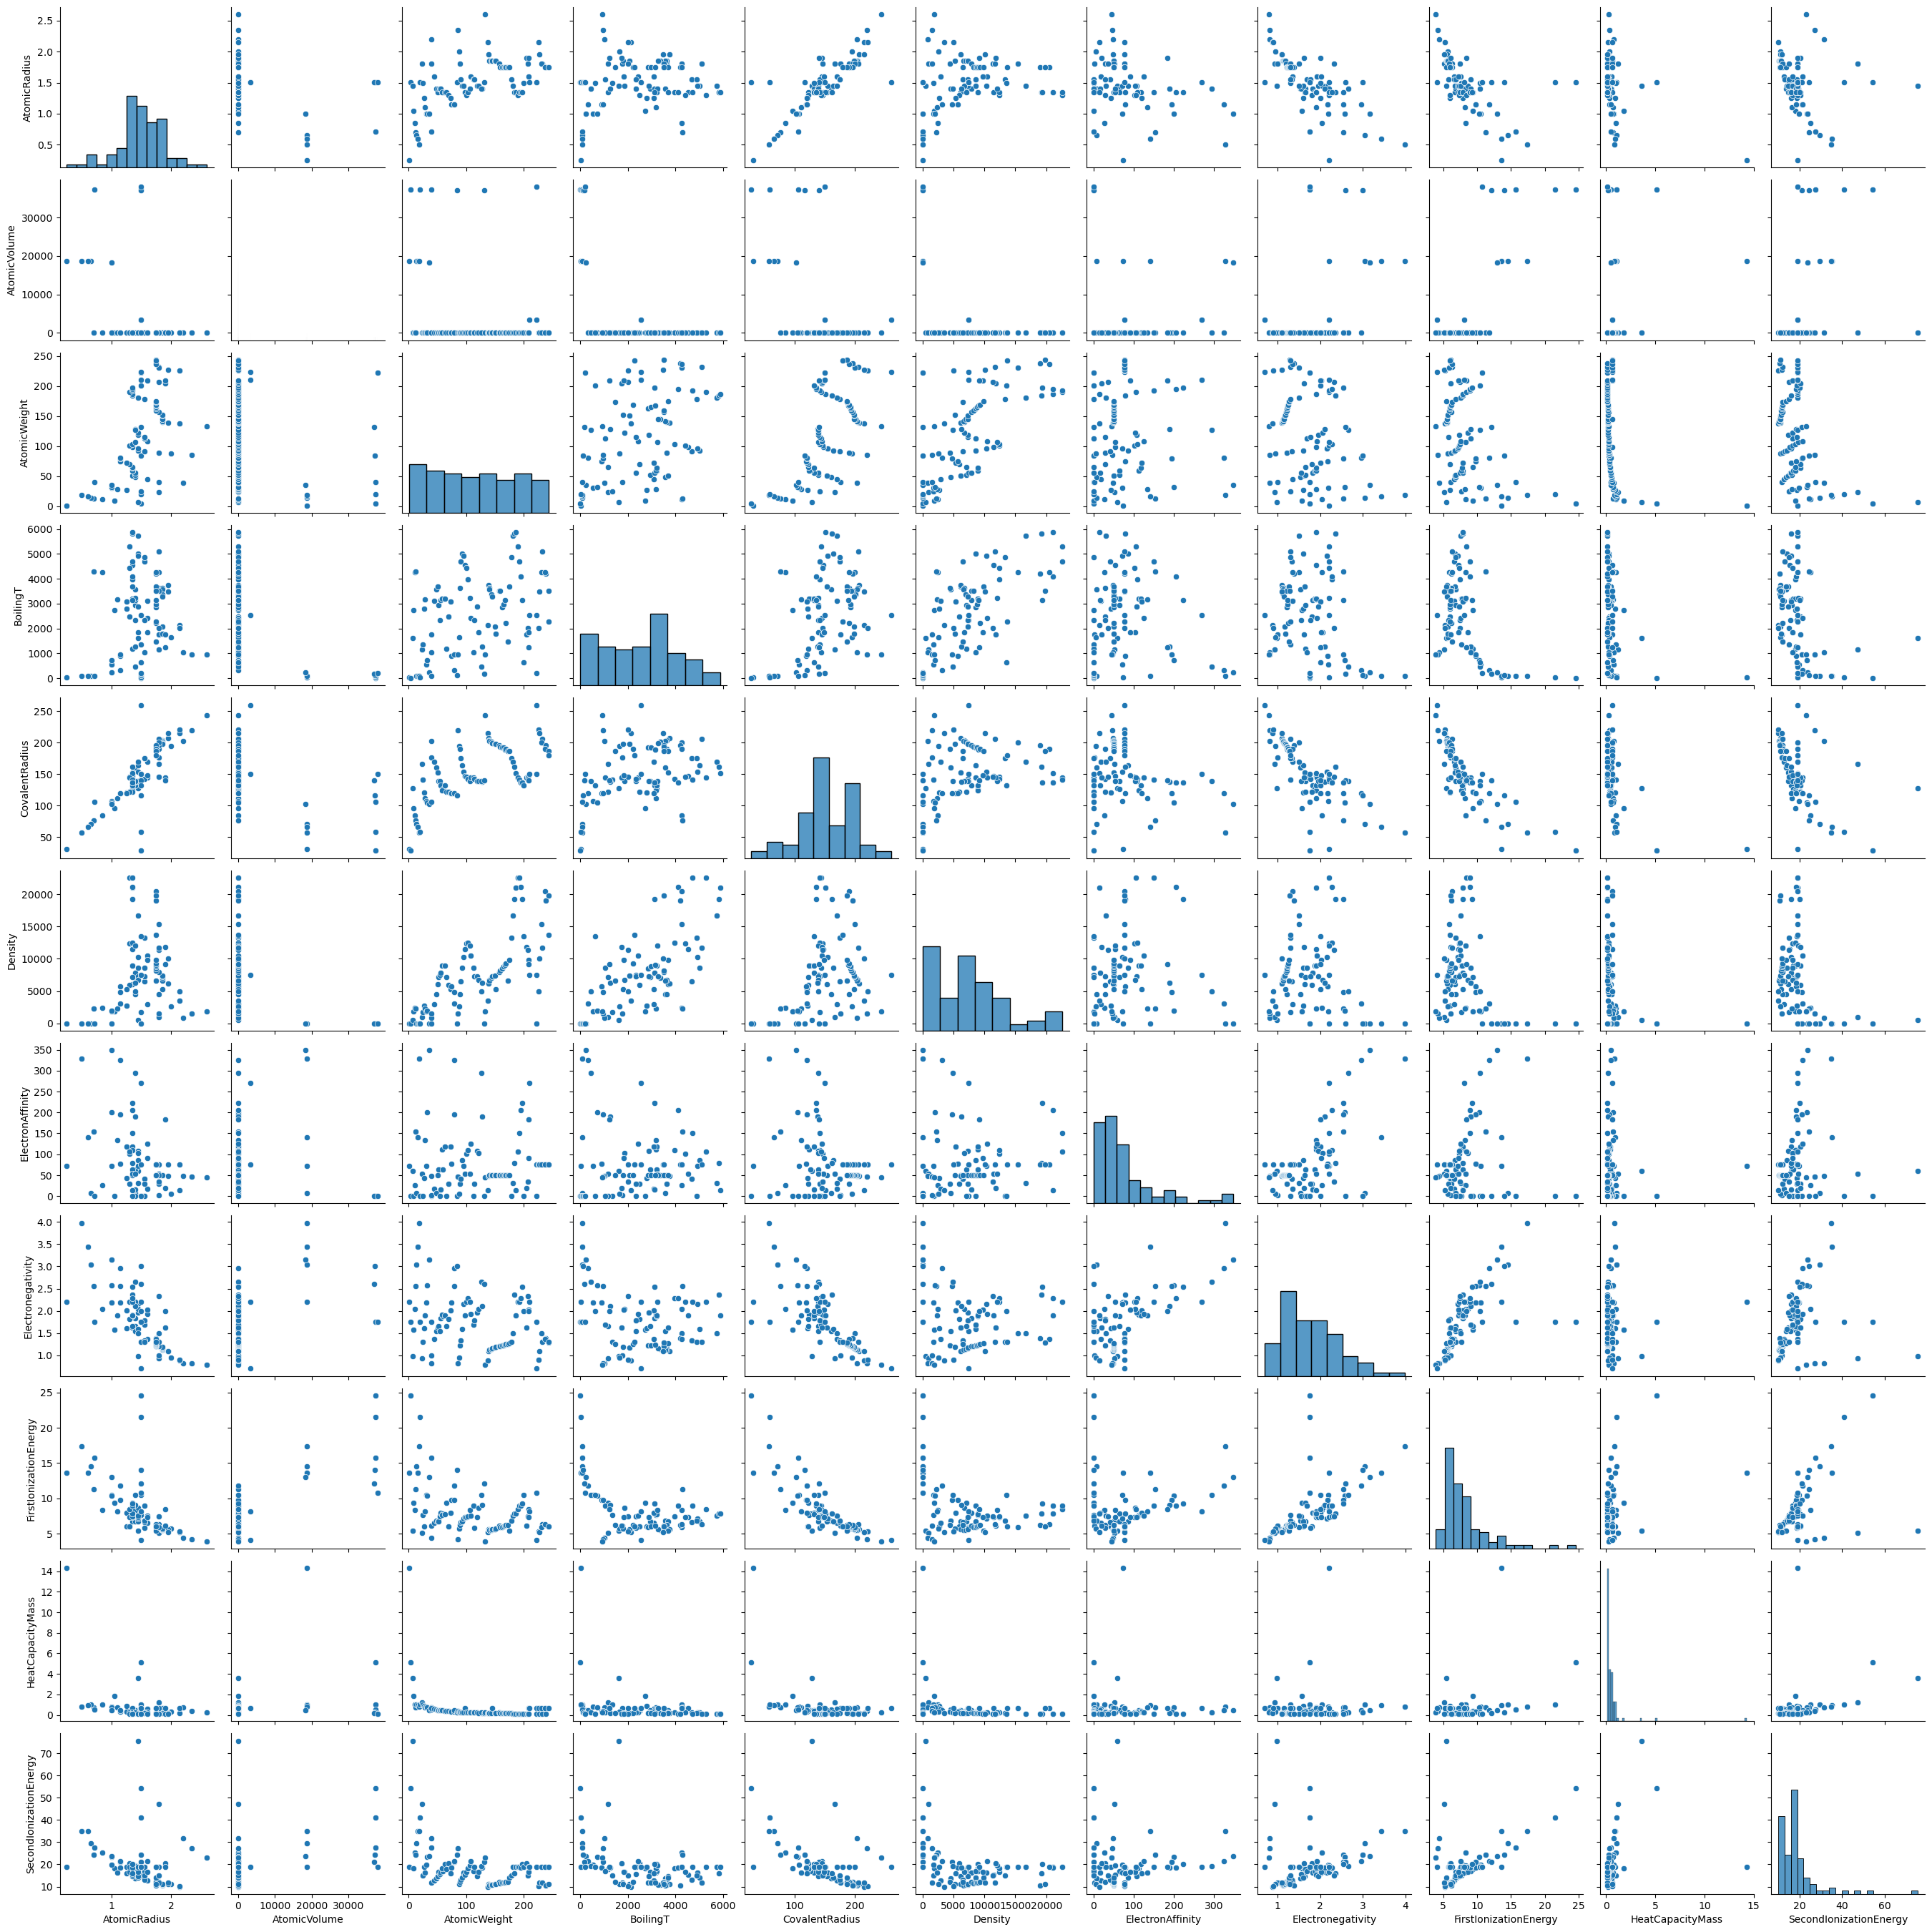

In [ ]:
features = [c for c in element_data.columns]
grid = sns.pairplot(element_data[features])

In [ ]:
train_y

,band_gap,formation_energy_per_atom
formula,,
PtI2,1.2280,-0.165995
TiBr2,0.0000,-1.044361
WI2,1.9586,-0.208133
Mg3Br,0.0000,-0.118789
NpBr3,0.0000,-1.358265
...,...,...
CdI2,2.4223,-0.592137
HfBr4,4.2902,-1.394327
SmBr,0.0000,-1.149715


## **Conclusion**
Congratulations! You have completed the lesson on exploring materials project data and predicting material properties. We covered data access, cleaning, manipulation, visualization, and machine learning using Python and various libraries.

Keep exploring and experimenting with different data analysis techniques and machine learning models to gain deeper insights into materials science and make accurate predictions for material properties.